# Experimenting on MNIST

### About MNIST Dataset

 The **MNIST** database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems
 
 The **MNIST** database contains 60,000 training images and 10,000 testing images.
 Photo size: **28x28 p**.

[Original Dataset](https://www.kaggle.com/code/jedrzejdudzicz/mnist-dataset-100-accuracy)

### The Purpose of notebook

I will design and try two neural networks to get ~100% accuracy
- MLP (Multilayer perceptron)

- CNN (Convolutional neural network)

**Update:**
- I made this notebook 7 months ago, and it is one of my first data science projects. During this time I learned a lot of interesting things and put these things in here.

### Importing libs

In [1]:
import numpy as np
import pandas as pd

np.random.seed(0) 
import random

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'

##  Reading data

In [2]:
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
train = pd.read_csv("../mnist/digit-recognizer/train.csv")
test = pd.read_csv("../mnist/digit-recognizer/test.csv")

X_train = train.drop(labels = ["label"], axis = 1)
y_train = train['label']

X_test = test

print(X_train.shape, X_test.shape)

(42000, 784) (28000, 784)


## Exploratory Data Analysis

In [3]:
X_train_plot = X_train.values.reshape(-1, 28, 28)

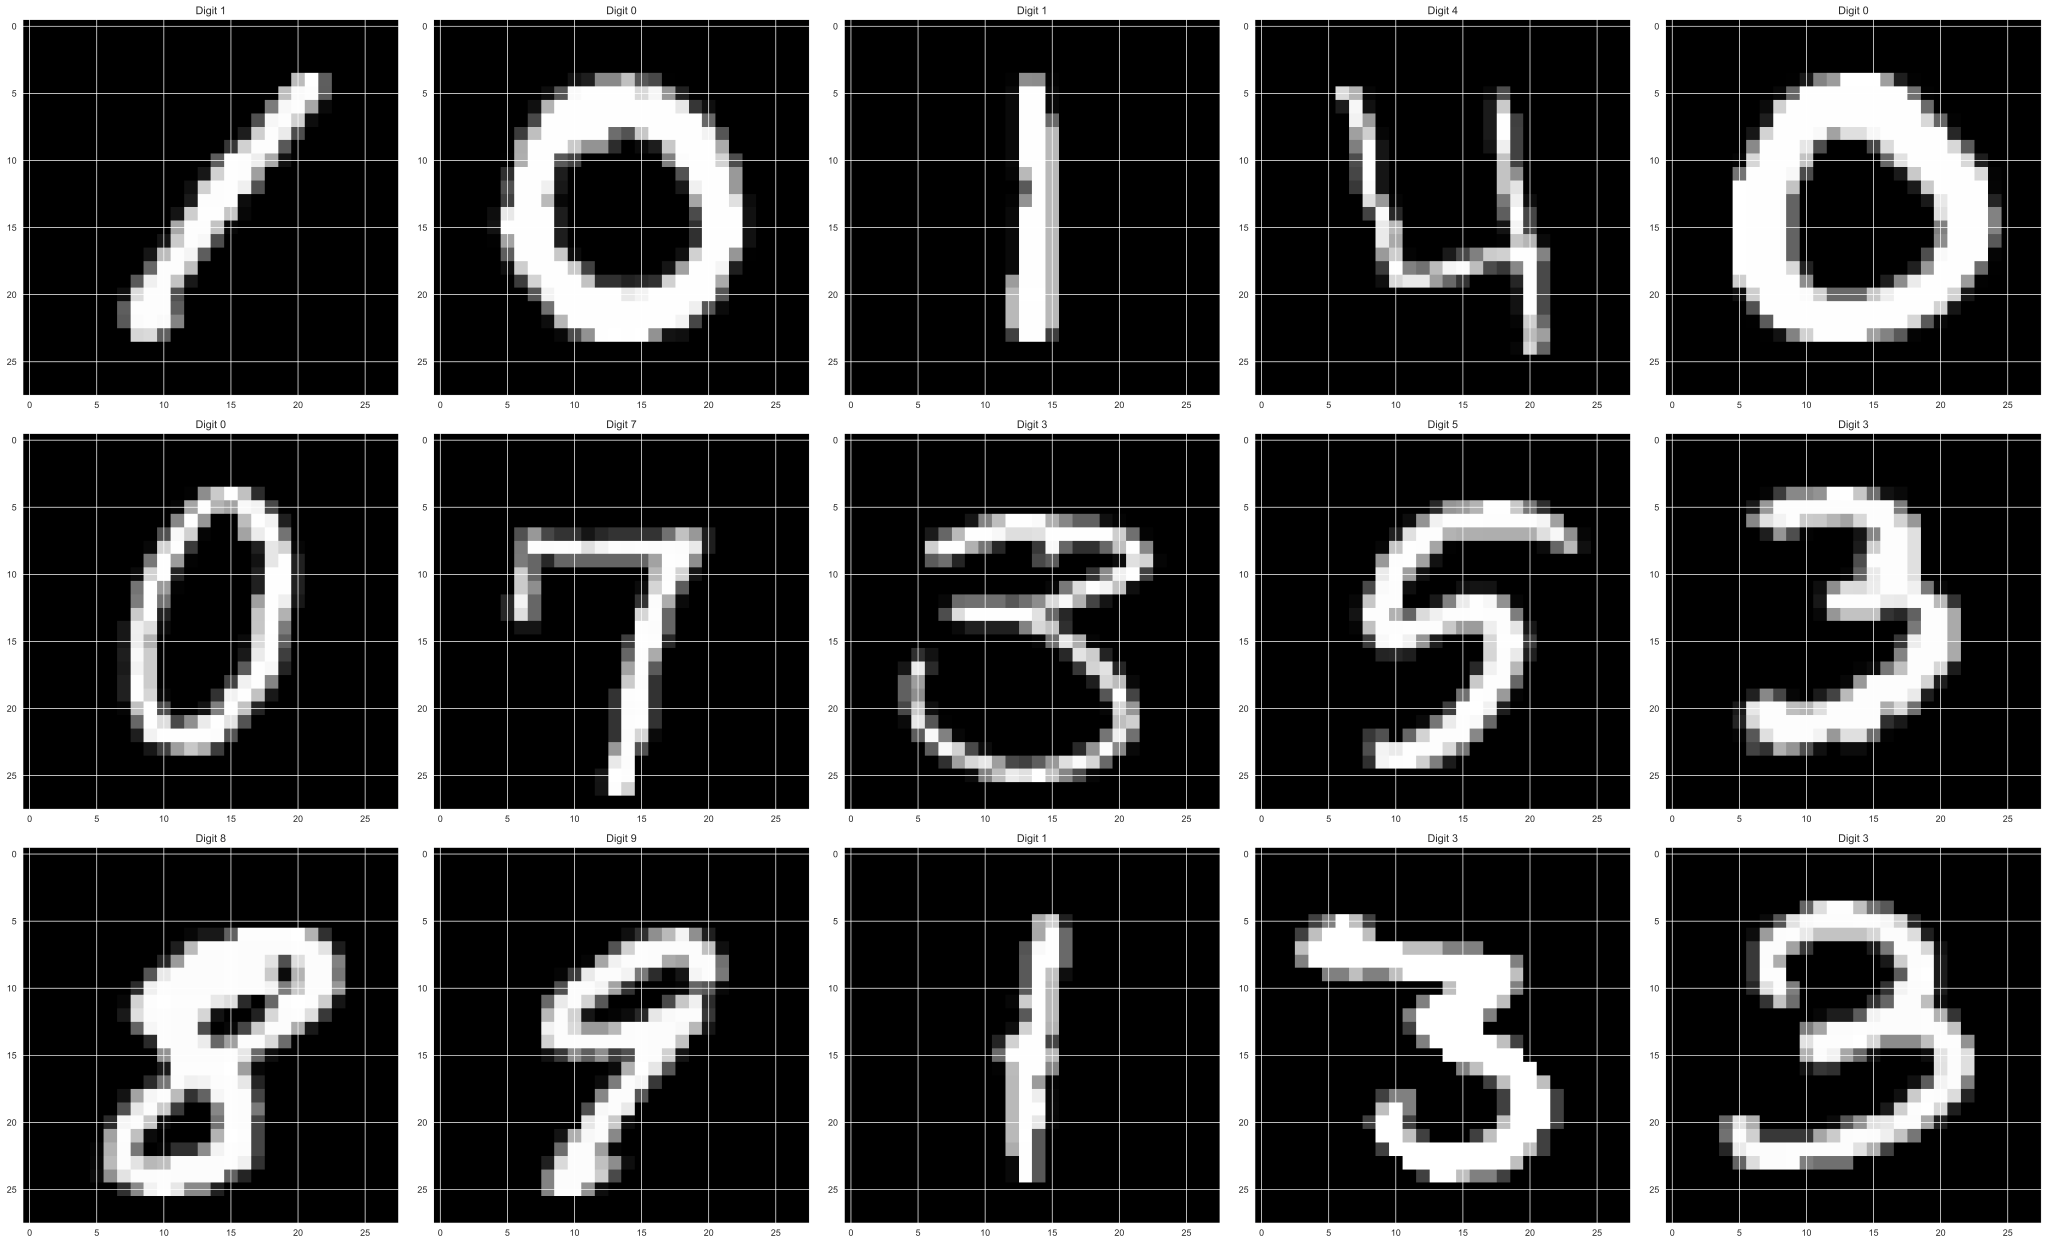

In [4]:
def show_example_digits(mono = 'gray'):
    plt.figure(figsize = (32, 32))
    for idx in range(15):
        plt.subplot(5, 5,idx+1)
        plt.imshow(X_train_plot[idx], cmap = mono)
        plt.title("Digit {}".format(y_train[idx]))
        
    plt.tight_layout()
    
show_example_digits()

In [5]:
# Function return digit in grayscale
def plot_digit(digit, dem = 28, font_size = 12):
    max_ax = font_size * dem
    
    plt.figure(figsize=(13, 13))
    plt.xlim([0, max_ax])
    plt.ylim([0, max_ax])
    plt.axis('off')
    black = '#000000'
    
    for idx in range(dem):
        for jdx in range(dem):

            t = plt.text(idx * font_size, max_ax - jdx*font_size, digit[jdx][idx], fontsize = font_size, color = black)
            c = digit[jdx][idx] / 255.
            t.set_bbox(dict(facecolor=(c, c, c), alpha = 0.5, edgecolor = 'black'))
            
    plt.show()

6


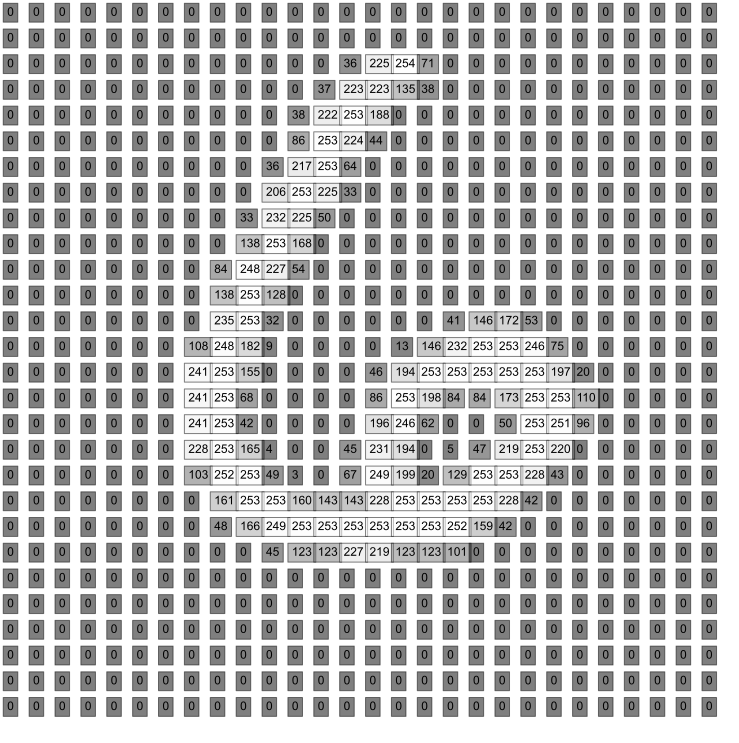

In [6]:
rand_number = random.randint(0, len(y_train))
print(y_train[rand_number])
plot_digit(X_train_plot[rand_number])

#### Chart of the number of digits in the data

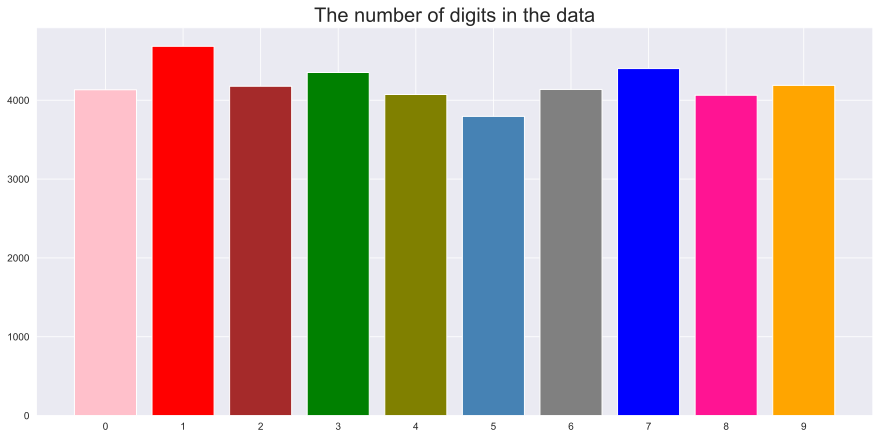

In [7]:
digit_range = np.arange(10)

val = y_train.value_counts().index
cnt = y_train.value_counts().values
mycolors = ['red', 'blue', 'green', 'orange', 'brown', 'grey', 'pink', 'olive', 'deeppink', 'steelblue']

plt.figure(figsize = (15, 7))
plt.title("The number of digits in the data", fontsize = 20)
plt.xticks(range(10))
plt.bar(val, cnt, color = mycolors);

## Initialize Parameters

In [8]:
EPOCHS_MLP = 40
EPOCHS_CNN = 2

## Data Preparing

In [9]:
img_rows, img_cols = 28, 28

num_pixels = X_train.shape[1] 

# input_shape = (img_rows, img_cols)

In [10]:
# Data Normalization [0, 1]
X_train /= 255
X_test /= 255

# one-hot encoding for target column
y_train = to_categorical(y_train)

# | [0, 1, 2, ... , 9] | = 10
num_classes = y_train.shape[1]

# Number of objects, vector size (28 * 28)
print(X_train.shape, X_test.shape)

(42000, 784) (28000, 784)


#### Split data

added stratified folds

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 2, stratify=y_train)

## MLP ([Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))

### Structure

Firstly, let's think how the network should look like. It will have three layers:

1 Input Layer

2 Hidden Layer

3 Output Layer


![MLP](https://miro.medium.com/max/700/1*-IPQlOd46dlsutIbUq1Zcw.png)

Input layer has 28 * 28 pixels reshape to vector

Hidden layer has a lot of neurons

Output layer has 10 neurons 

Design network with using keras 

The metrics we use are f1_score

In [12]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### Function to drawing learning curve history learning neural network



In [13]:
def draw_learning_curve(history):
    keys=['f1', 'loss']
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
        plt.tight_layout()
    plt.show()

# Adding Callbacks
- EarlyStopping (Stop training when a monitored metric has stopped improving)
- ReduceLROnPlateau (Reduce learning rate when a metric has stopped improving)
- ModelCheckpoint (Callback to save the Keras model or model weights at some frequency)

In [14]:
def callbacks(name): 
    return [ 
        EarlyStopping(monitor = 'loss', patience = 6), 
        ReduceLROnPlateau(monitor = 'loss', patience = 3), 
        ModelCheckpoint(f'../results_keras/{name}.hdf5', save_best_only=True) # saving the best model
    ]

#### Simple MLP with one hidden layer

In [15]:
def get_mlp():
    
    return Sequential([
        #input layer is automatic generation by keras
        
        #hidden layer
        Dense(512, input_dim = num_pixels, activation='relu'),
        
        #output layer
        Dense(num_classes, activation='softmax')
    ])

In [16]:
model = get_mlp()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


Our network has 407,050 params (weights)

#### You can use **GPU** to accelerate training

In [17]:
learning_history = model.fit(X_train, y_train,
          batch_size = 1024, epochs = EPOCHS_MLP, verbose = 2, callbacks = callbacks('simple_mlp'),
          validation_data=(X_val, y_val));

Epoch 1/40
37/37 - 2s - loss: 0.7047 - f1: 0.7090 - val_loss: 0.3262 - val_f1: 0.9021 - lr: 0.0010 - 2s/epoch - 64ms/step
Epoch 2/40
37/37 - 0s - loss: 0.2728 - f1: 0.9226 - val_loss: 0.2478 - val_f1: 0.9314 - lr: 0.0010 - 283ms/epoch - 8ms/step
Epoch 3/40
37/37 - 0s - loss: 0.2123 - f1: 0.9411 - val_loss: 0.2059 - val_f1: 0.9420 - lr: 0.0010 - 295ms/epoch - 8ms/step
Epoch 4/40
37/37 - 0s - loss: 0.1747 - f1: 0.9522 - val_loss: 0.1775 - val_f1: 0.9468 - lr: 0.0010 - 265ms/epoch - 7ms/step
Epoch 5/40
37/37 - 0s - loss: 0.1479 - f1: 0.9600 - val_loss: 0.1555 - val_f1: 0.9522 - lr: 0.0010 - 263ms/epoch - 7ms/step
Epoch 6/40
37/37 - 0s - loss: 0.1258 - f1: 0.9658 - val_loss: 0.1390 - val_f1: 0.9576 - lr: 0.0010 - 263ms/epoch - 7ms/step
Epoch 7/40
37/37 - 0s - loss: 0.1079 - f1: 0.9713 - val_loss: 0.1263 - val_f1: 0.9604 - lr: 0.0010 - 249ms/epoch - 7ms/step
Epoch 8/40
37/37 - 0s - loss: 0.0946 - f1: 0.9745 - val_loss: 0.1173 - val_f1: 0.9615 - lr: 0.0010 - 265ms/epoch - 7ms/step
Epoch 9/40

In [18]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 8.045635372400284%
Test score: 97.53110408782959%
MLP Error: 2.47%


C:\Users\radiu\AppData\Local\Temp\ipykernel_25532\2143632769.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


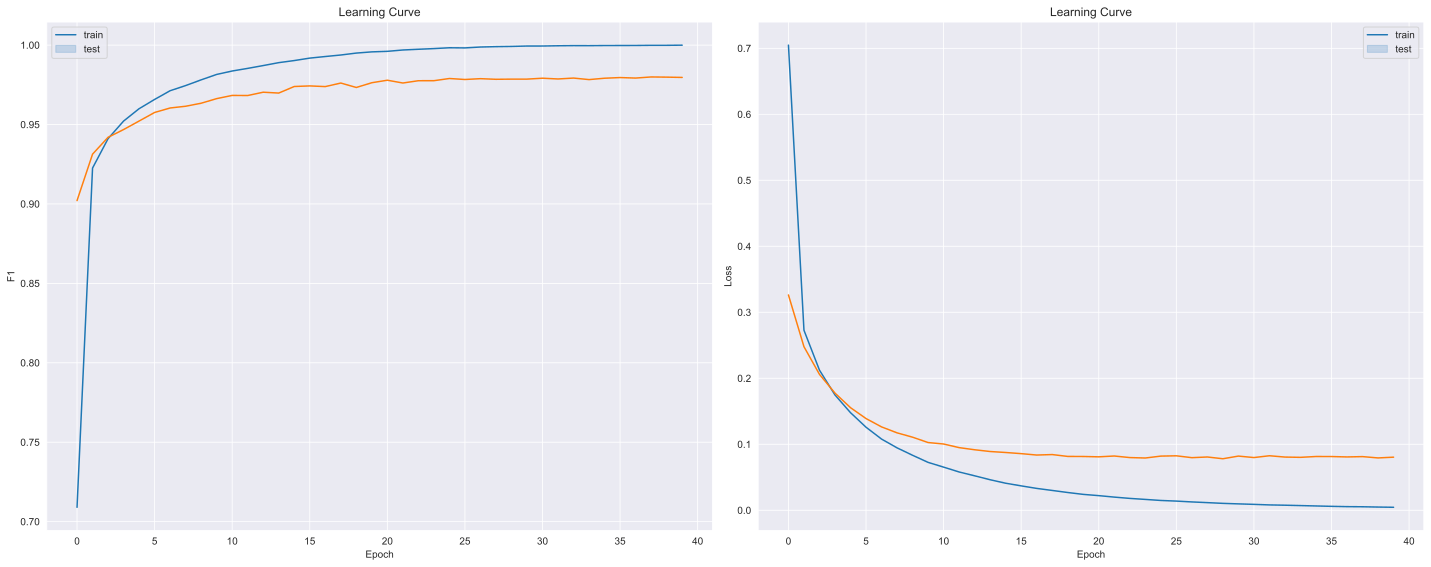

In [19]:
draw_learning_curve(learning_history)

Cool! I get ~98% accuracy with easy model MLP and i didn't work too much.

According to Pareto principle 80/20 in this case 20% work generate ~80%~ 98% accuracy :)

#### Adding new layer and Dropout to avoid overfitting

In [20]:
def get_mlpv2():
    
    return Sequential([
        Dense(512, input_dim=num_pixels, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

In [21]:
model = get_mlpv2()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 567,434
Trainable params: 567,434
Non-tr

Run new model 

In [22]:
learning_history = model.fit(X_train, y_train,
          batch_size = 1024, epochs = EPOCHS_MLP, verbose = 2, callbacks = callbacks('mlp_reg'),
          validation_data=(X_val, y_val));

Epoch 1/40
37/37 - 1s - loss: 0.7606 - f1: 0.6911 - val_loss: 0.2793 - val_f1: 0.9138 - lr: 0.0010 - 942ms/epoch - 25ms/step
Epoch 2/40
37/37 - 0s - loss: 0.2553 - f1: 0.9230 - val_loss: 0.1797 - val_f1: 0.9443 - lr: 0.0010 - 297ms/epoch - 8ms/step
Epoch 3/40
37/37 - 0s - loss: 0.1745 - f1: 0.9474 - val_loss: 0.1325 - val_f1: 0.9546 - lr: 0.0010 - 281ms/epoch - 8ms/step
Epoch 4/40
37/37 - 0s - loss: 0.1377 - f1: 0.9592 - val_loss: 0.1152 - val_f1: 0.9630 - lr: 0.0010 - 265ms/epoch - 7ms/step
Epoch 5/40
37/37 - 0s - loss: 0.1102 - f1: 0.9671 - val_loss: 0.1068 - val_f1: 0.9658 - lr: 0.0010 - 273ms/epoch - 7ms/step
Epoch 6/40
37/37 - 0s - loss: 0.0923 - f1: 0.9718 - val_loss: 0.0889 - val_f1: 0.9673 - lr: 0.0010 - 285ms/epoch - 8ms/step
Epoch 7/40
37/37 - 0s - loss: 0.0753 - f1: 0.9774 - val_loss: 0.0833 - val_f1: 0.9770 - lr: 0.0010 - 266ms/epoch - 7ms/step
Epoch 8/40
37/37 - 0s - loss: 0.0647 - f1: 0.9803 - val_loss: 0.0811 - val_f1: 0.9756 - lr: 0.0010 - 302ms/epoch - 8ms/step
Epoch 9

C:\Users\radiu\AppData\Local\Temp\ipykernel_25532\2143632769.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


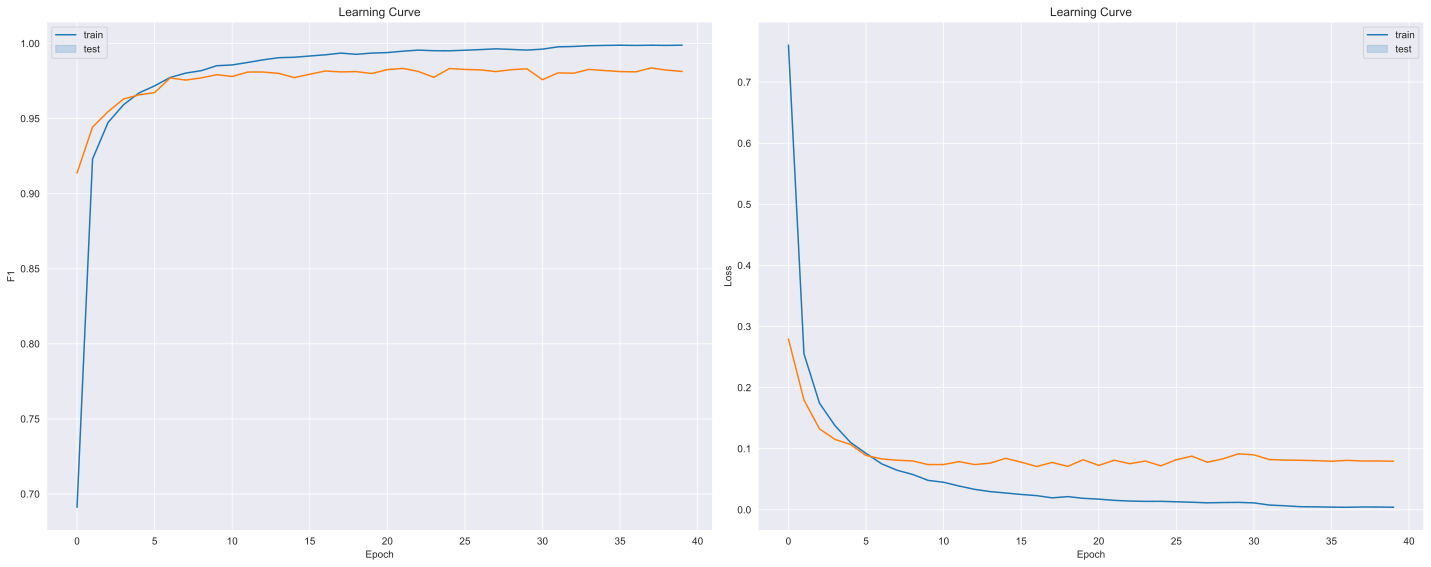

In [23]:
draw_learning_curve(learning_history)

In [24]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 7.939844578504562%
Test score: 97.9516088962555%
MLP Error: 2.05%


#### I slightly improved the model, so we keep working.

## CNN ([Convolutional_neural_network](https://en.wikipedia.org/wiki/Convolutional_neural_network))

![CNN](https://miro.medium.com/max/1872/1*SGPGG7oeSvVlV5sOSQ2iZw.png)

CNN consists with:
- convolution layer
- in the past MLP

It will use 3 convolutional layers: (Conv2D, Conv2D, pool)

#### We need to reshape data.

In [25]:
X_train.shape

(37800, 784)

In [26]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_val = X_val.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)
input_shape = (img_rows, img_cols, 1)

In [27]:
def get_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation = "softmax")
        
    ])

In [28]:
model = get_cnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        36928     
                                                      

In [29]:
learning_history = model.fit(X_train, y_train,
          batch_size = 128,
          epochs = EPOCHS_CNN,
          verbose = 1,
          callbacks = callbacks('cnn_v1'),
          validation_data = (X_val, y_val))

Epoch 1/2
296/296 [==============================] - 8s 13ms/step - loss: 0.4957 - f1: 0.8168 - val_loss: 0.0973 - val_f1: 0.9712 - lr: 0.0010
Epoch 2/2
296/296 [==============================] - 4s 12ms/step - loss: 0.1092 - f1: 0.9688 - val_loss: 0.0445 - val_f1: 0.9879 - lr: 0.0010


In [30]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.04446927830576897
Test score: 0.9878921508789062
CNN Error: 1.21%


C:\Users\radiu\AppData\Local\Temp\ipykernel_25532\2143632769.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


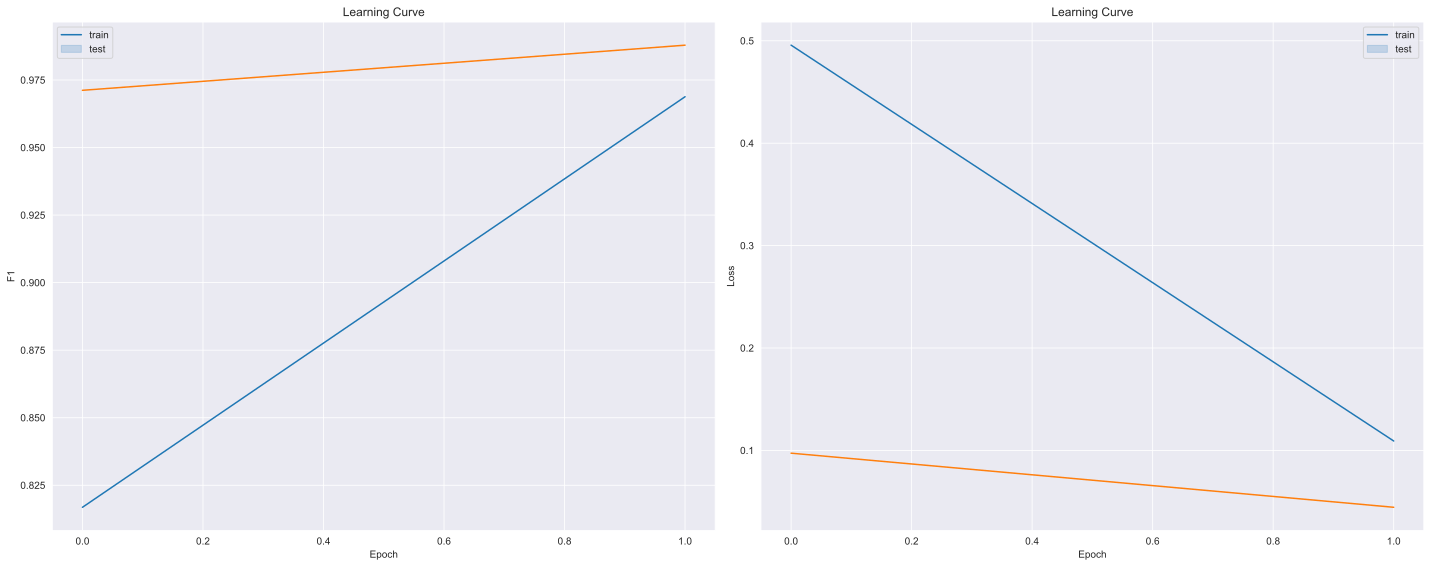

In [31]:
draw_learning_curve(learning_history)

### Let's see in which cases the model is invalid.

#### Let's assign the values provided by the model

In [32]:
y_pred = model.predict(X_val)

132/132 [==============================] - 1s 3ms/step


#### I made function to visual output

In [33]:
def draw_output(idx_nums):
    plt.figure(figsize = (20, 20))
    plt.xticks( range(10) )
    x = np.ceil(np.sqrt(len(idx_nums)))
    cnt = 1
    for ph in idx_nums:
        plt.subplot(x, x, cnt)
        curr_photo = y_val[ph]
        
        plt.xlim(0, 10)
        plt.title("Digit: {0}\n idx: {1} ".format(np.argmax(y_val[ph]), ph), fontsize = 10) 
        plt.bar(range(10), y_pred[ph])
        
        cnt += 1

#### The number of errors for the each digit

In [34]:
cnt_error = []
for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    cnt_error.append(np.argmax(a))

cnt_error = np.unique(cnt_error, return_counts = True)
cnt_error[0]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

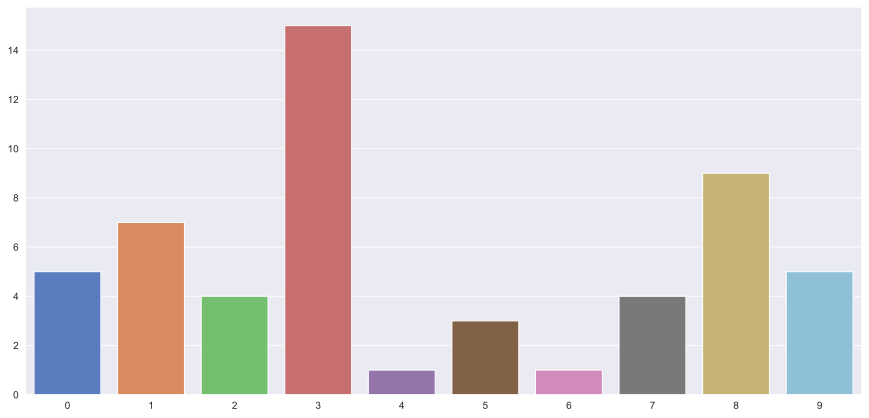

In [35]:
sns.set_style("darkgrid")
plt.figure(figsize = (15, 7))
bar_plot = sns.barplot(x=cnt_error[0], y=cnt_error[1], palette="muted")
plt.show()

#### Let's see these photos (2, 9)

C:\Users\radiu\AppData\Local\Temp\ipykernel_25532\3538774226.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


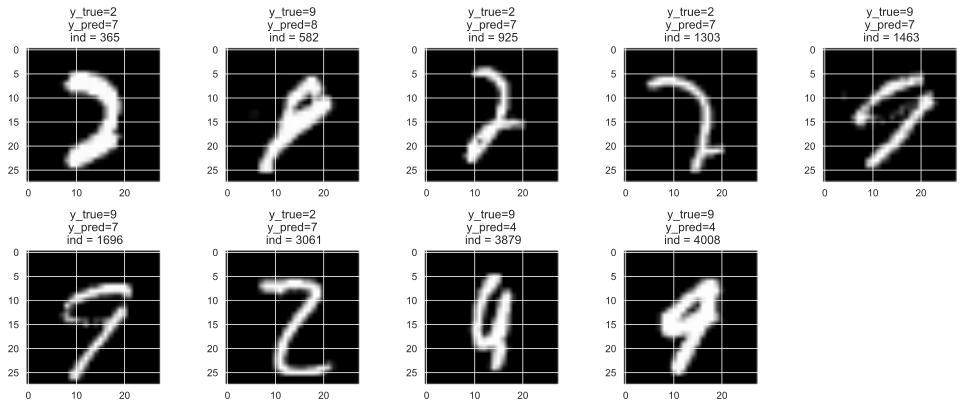

In [36]:
cnt_ind = 1
list_idx = []
X_val_plot = X_val.reshape( X_val.shape[:-1] )
fig = plt.figure(figsize=(14, 14))

for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    if np.argmax(a) == 2 or np.argmax(a) == 9:
        plt.subplot(5, 5, cnt_ind)
        plt.imshow(X_val_plot[idx], cmap='gray', interpolation='none')
        plt.title('y_true={0}\ny_pred={1}\n ind = {2}'.format(np.argmax(a), np.argmax(b), idx))
        plt.tight_layout()
        list_idx.append(idx)
        cnt_ind += 1

#### Run the `draw_output` function to see the probability of each value occurring

In [37]:
# draw_output(list_idx)

#### As you can see, the model is wrong in cases where the common person would also have trouble finding the correct answer.

## Data Augmentation

#### I will try to improve the result by expanding the data. You have to be careful when rotating your photos not to misclassify numbers such as 9 and 6.

#### Data augmentation:

Randomly shift images horizontally by 10% of the width

Randomly shift images vertically by 10% of the height

Randomly rotate images by 10 degrees

Randomly Zoom by 10% some images


In [38]:
train_aug = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        fill_mode = 'nearest',
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)
        

train_aug.fit(X_train)
train_gen = train_aug.flow(X_train, y_train, batch_size=64)

#### Building new model and using batch normalization

In [39]:
def get_cnn_v2():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
          
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(num_classes, activation = "softmax")
        
    ])

In [40]:
model = get_cnn_v2()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)       

In [41]:
learning_history = model.fit(train_gen, epochs = EPOCHS_CNN,
                               steps_per_epoch = X_train.shape[0] // 64,
                               validation_data = (X_val, y_val),
                               callbacks = callbacks('best_cnn'),
                             )

Epoch 1/2
590/590 [==============================] - 15s 23ms/step - loss: 0.6727 - f1: 0.7738 - val_loss: 0.2987 - val_f1: 0.9111 - lr: 0.0010
Epoch 2/2
590/590 [==============================] - 13s 22ms/step - loss: 0.1714 - f1: 0.9520 - val_loss: 0.0842 - val_f1: 0.9753 - lr: 0.0010


#### Loading the best model

In [42]:
model = load_model('../results_keras/best_cnn.hdf5', custom_objects={"f1": f1})

In [43]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.08416060358285904
Test score: 0.9752993583679199
CNN Error: 2.47%


C:\Users\radiu\AppData\Local\Temp\ipykernel_25532\2143632769.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


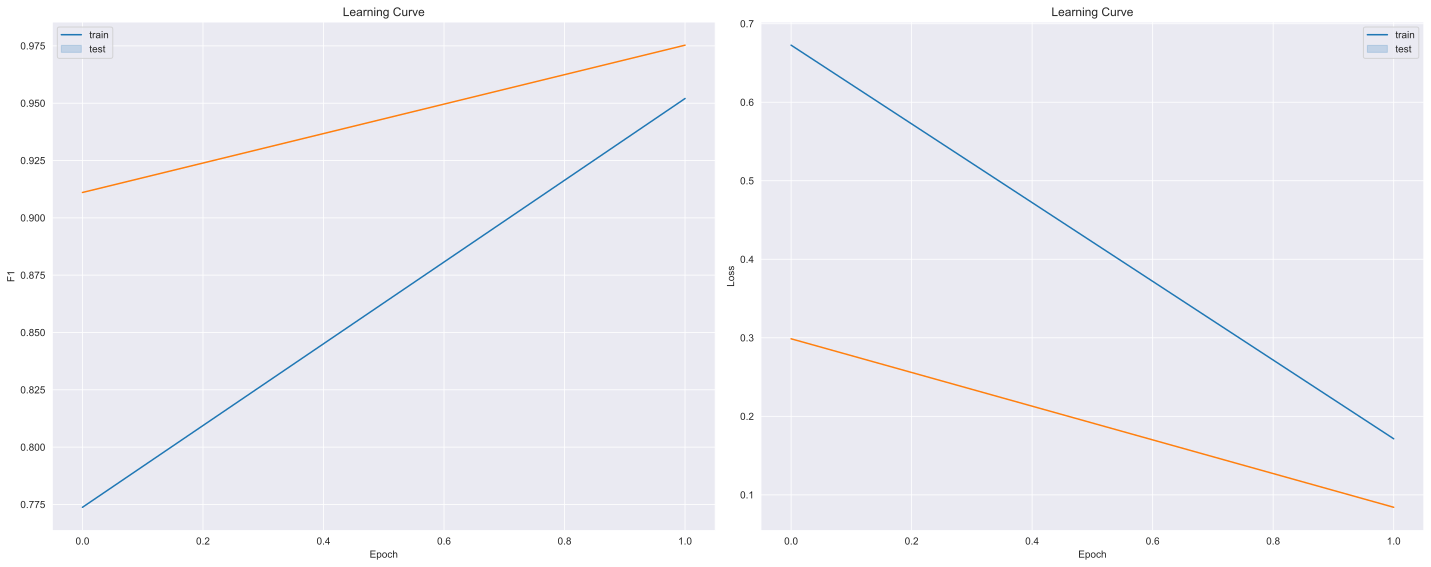

In [44]:
draw_learning_curve(learning_history)

#### We achieved a great result of 99.6% accuracy

# Generate output

In [45]:
output = model.predict(X_test)

output = np.argmax(output, axis = 1)

output = pd.Series(output, name="Label")

submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), output], axis = 1)

submission.to_csv("../results_keras/submission.csv", index=False)

875/875 [==============================] - 3s 4ms/step


# Bonus

Let's see, using additional data, how this will affect the final result.

In [46]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

(x_train1, y_train1), (x_test1, y_test1) = load_data('../mnist/digit-recognizer/mnist.npz')

In [47]:
x_train1 = x_train1 / 255
x_test1 = x_test1 / 255

x_train1 = x_train1.reshape(-1, 28, 28, 1)
x_test1 = x_test1.reshape(-1, 28, 28, 1)

y_train1 = y_train1.reshape(y_train1.shape[0], 1)
y_test1 = y_test1.reshape(y_test1.shape[0], 1)

In [48]:
Add_X = np.vstack((x_train1, x_test1))

Add_y = np.vstack((y_train1, y_test1))

Add_y = to_categorical(Add_y)

In [49]:
train = pd.read_csv("../mnist/digit-recognizer/train.csv")

X_train = train.drop(labels = ["label"], axis = 1)
y_train = train['label']
y_train = to_categorical(y_train)

X_train /= 255
X_train = X_train.values.reshape(-1, 28, 28, 1)

In [50]:
add_train_aug = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        fill_mode = 'nearest',
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)
        

add_train_aug.fit(Add_X)
add_train_gen = add_train_aug.flow(Add_X, Add_y, batch_size=64)

In [51]:
model = get_cnn_v2()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 64)       

In [52]:
learning_history = model.fit(add_train_gen, epochs = EPOCHS_CNN,
                               steps_per_epoch = x_train1.shape[0] // 64,
                               validation_data = (X_val, y_val),
                               callbacks = callbacks('cnn_bonus'),
                             )

Epoch 1/2
937/937 [==============================] - 21s 21ms/step - loss: 0.4887 - f1: 0.8401 - val_loss: 0.0527 - val_f1: 0.9848 - lr: 0.0010
Epoch 2/2
937/937 [==============================] - 20s 21ms/step - loss: 0.1285 - f1: 0.9638 - val_loss: 0.0416 - val_f1: 0.9868 - lr: 0.0010


In [53]:
model = load_model('../results_keras/cnn_bonus.hdf5', custom_objects={"f1": f1})

In [54]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.04164617508649826
Test score: 0.9868438243865967
CNN Error: 1.32%


C:\Users\radiu\AppData\Local\Temp\ipykernel_25532\2143632769.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


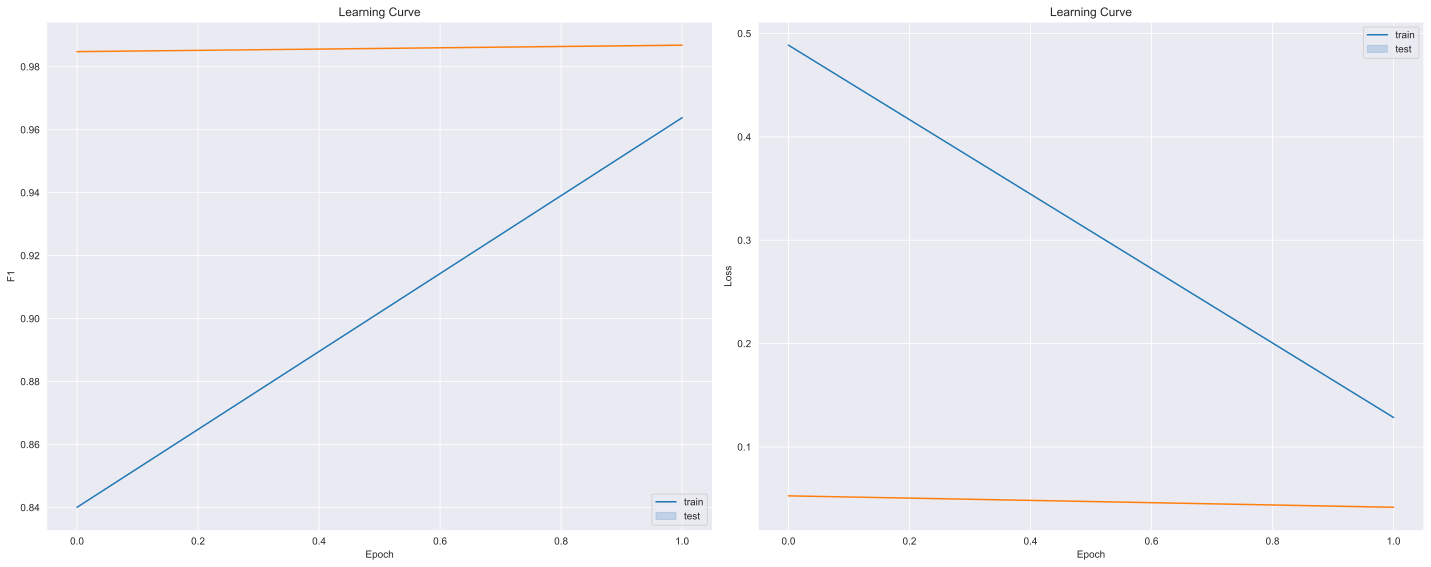

In [55]:
draw_learning_curve(learning_history)

#### As you can see, even with such a large data set, we do not get 100% accuracy

## Visualize Model

In [56]:
# plot_model(model)

# Occlusion sensitivity

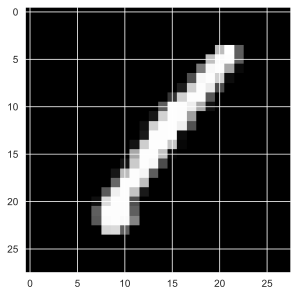

In [57]:
plt.imshow(X_train[0].reshape(28, 28), cmap='gray');

In [58]:
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 0

    return patched_image


img = X_train[0]

PATCH_SIZE = 4
sensitivity_map = np.zeros((img.shape[0], img.shape[0]))

for top_left_x in range(0, img.shape[0], PATCH_SIZE):
    for top_left_y in range(0, img.shape[1], PATCH_SIZE):
        patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)
        
        
        predicted_classes = model.predict(np.array([patched_image]))[0]
        confidence = predicted_classes[1]
        
        sensitivity_map[
            top_left_y:top_left_y + PATCH_SIZE,
            top_left_x:top_left_x + PATCH_SIZE,
        ] = confidence
        

1/1 [==============================] - 0s 24ms/step


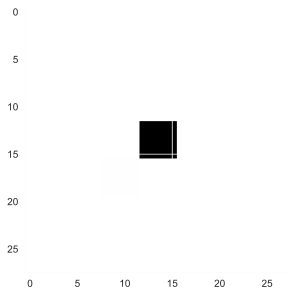

In [59]:
plt.imshow(sensitivity_map, cmap='gray');

# Generate bonus output

In [60]:
output = model.predict(X_test)

output = np.argmax(output, axis = 1)

output = pd.Series(output, name="Label")

submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), output], axis = 1)

submission.to_csv("../results_keras/bonus_submission.csv", index=False)

875/875 [==============================] - 4s 4ms/step


### Final step: Conclusions

#### I achieved the following results:
- MLP: ~98% f1
- CNN: ~100% f1

I have created a model that recognizes handwritten numbers. You can try to get more data to make the model even better.


#### This is my first notebook.

#### I would love to know your comments and note about this.

<font size="3">
    <div style="text-align: right"> <b> Author </b> </div>
</font>
<div style="text-align: right"> Jędrzej </div>
<div style="text-align: right"> Dudzicz </div>